In [1]:
import pandas as pd
import numpy as np

In [2]:
ml1m_rating = pd.read_csv("/home/rohit/rs_system_project/neural-collaborative-filtering/src/data/ml-1m/ratings.csv")

In [5]:
ml1m_rating.head()

,origin_uid,origin_iid,rating,timestamp,userId,itemId
0,1,1193,5,978300760,0,0
1,1,661,3,978302109,0,1
2,1,914,3,978301968,0,2
3,1,3408,4,978300275,0,3
4,1,2355,5,978824291,0,4


In [13]:
ml1m_rating.shape

(1000209, 6)

In [7]:
len(ml1m_rating.userId.unique()), len(ml1m_rating.origin_iid.unique())

(6040, 3706)

In [8]:
ml1m_dir = "/home/rohit/rs_system_project/neural-collaborative-filtering/src/data/ml-1m/ratings.dat"
ml1m_rating_dat = pd.read_csv(ml1m_dir, sep='::', header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')


In [9]:
ml1m_rating_dat.head()

,uid,mid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
# Reindex
user_id = ml1m_rating_dat[['uid']].drop_duplicates().reindex()
user_id['userId'] = np.arange(len(user_id))
ml1m_rating_dat = pd.merge(ml1m_rating_dat, user_id, on=['uid'], how='left')
item_id = ml1m_rating_dat[['mid']].drop_duplicates()
item_id['itemId'] = np.arange(len(item_id))
ml1m_rating_dat = pd.merge(ml1m_rating_dat, item_id, on=['mid'], how='left')
ml1m_rating_dat = ml1m_rating_dat[['userId', 'itemId', 'rating', 'timestamp']]

In [15]:
ml1m_rating_dat.head()

,userId,itemId,rating,timestamp
604053,3674,1230,3,966368164
311586,1855,856,5,974697348
488263,3002,4,4,970773987
796828,4773,916,4,963057488
607744,3687,350,4,966402313


In [12]:
ml1m_rating_dat.shape

(1000209, 4)

In [49]:
ml1m_rating_dat.iloc[0][2]

3

In [50]:
c = 0
for i in range(ml1m_rating_dat.shape[0]):
    if ml1m_rating_dat.iloc[i][2] > 0:
        c += 1
        
print(c)

1000209


In [14]:
ml1m_rating_dat = ml1m_rating_dat.sample(frac = 1)

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ml1m_rating_dat, test_size=0.2)

In [17]:
train.head()

,userId,itemId,rating,timestamp
491101,3018,1753,5,970505308
719779,4310,678,3,965258263
291451,1736,642,3,974706126
180282,1127,1291,3,974904975
69259,462,699,1,976228799


In [18]:
test.head()
y_true = test.rating

In [48]:
y_true

53953     4
460233    3
463903    5
884957    4
904871    5
         ..
937029    5
694109    5
459287    5
614881    4
936623    4
Name: rating, Length: 200042, dtype: int64

In [25]:
import keras
from keras.layers import Dense,Embedding,Input,Flatten, Dropout,BatchNormalization,merge,concatenate

In [23]:
n_latent_factors_user = 8
n_latent_factors_movie = 10
n_latent_factors_mf = 3
n_users, n_movies = len(ml1m_rating_dat.userId.unique()), len(ml1m_rating_dat.itemId.unique())

In [43]:
movie_input = Input(shape=[1], name = 'item')
movie_embed_mlp = Embedding(n_movies+1,n_latent_factors_movie, name='Movie-embedding-MLP')(movie_input)
movie_vec_mlp = Flatten(name='Flatten_movie_mlp')(movie_embed_mlp)
movie_vec_mlp = Dropout(0.2)(movie_vec_mlp)

movie_embed_mf = Embedding(n_movies+1,n_latent_factors_movie, name='Movie-embedding-mf')(movie_input)
movie_vec_mf = Flatten(name='Flatten_movie_mf')(movie_embed_mf)
movie_vec_mf = Dropout(0.2)(movie_vec_mf)


user_input = Input(shape=[1], name ='user')
user_vec_mlp = Embedding(n_users+1,n_latent_factors_user,name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='Flatten_user_mlp')(user_vec_mlp)
user_vec_mlp = Dropout(0.2)(user_vec_mlp)


user_vec_mf = Embedding(n_users+1,n_latent_factors_user,name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='Flatten_user_mf')(user_vec_mf)
user_vec_mf = Dropout(0.2)(user_vec_mf)

concat = concatenate([movie_vec_mlp,user_vec_mlp], axis = 1, name='Concat')
concat_dropout = Dropout(0.2)(concat)
dense = Dense(200, name='FC')(concat_dropout)
dense_batch = BatchNormalization(name = 'batch')(dense)
dropout_1 = Dropout(0.2, name="Dropout_1")(dense_batch)
dense_2 = Dense(100, name="FC_1")(dropout_1)
dense_batch_2 = BatchNormalization(name = 'batch_2')(dense_2)


dropout_2 = Dropout(0.2,name='Dropout_2')(dense_batch_2)
dense_3 = Dense(50,name='FC_2')(dropout_2)
dense_4 = Dense(20,name='FC_3', activation='relu')(dense_3)

pred_mf = concatenate([movie_vec_mf, user_vec_mf], axis = 1,name='Dot')


pred_mlp = Dense(1, activation='relu',name='Activation')(dense_4)

combine_mlp_mf = concatenate([pred_mf, pred_mlp], axis = 1,name='Concat_MF_MLP')
result_combine = Dense(100,name='Combine_MF_MLP')(combine_mlp_mf)
deep_combine = Dense(100,name='FC_4')(result_combine)




result = Dense(1,name='Prediction')(deep_combine)


model = keras.Model([user_input, movie_input], result)
#opt = keras.optimizers.Adam(lr =0.01)
model.compile(optimizer='adam',loss= 'binary_crossentropy')









In [44]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Movie-embedding-MLP (Embedding) (None, 1, 10)        37070       item[0][0]                       
__________________________________________________________________________________________________
user-embedding-mlp (Embedding)  (None, 1, 8)         48328       user[0][0]                       
____________________________________________________________________________________________

In [45]:
from keras.utils.vis_utils import plot_model

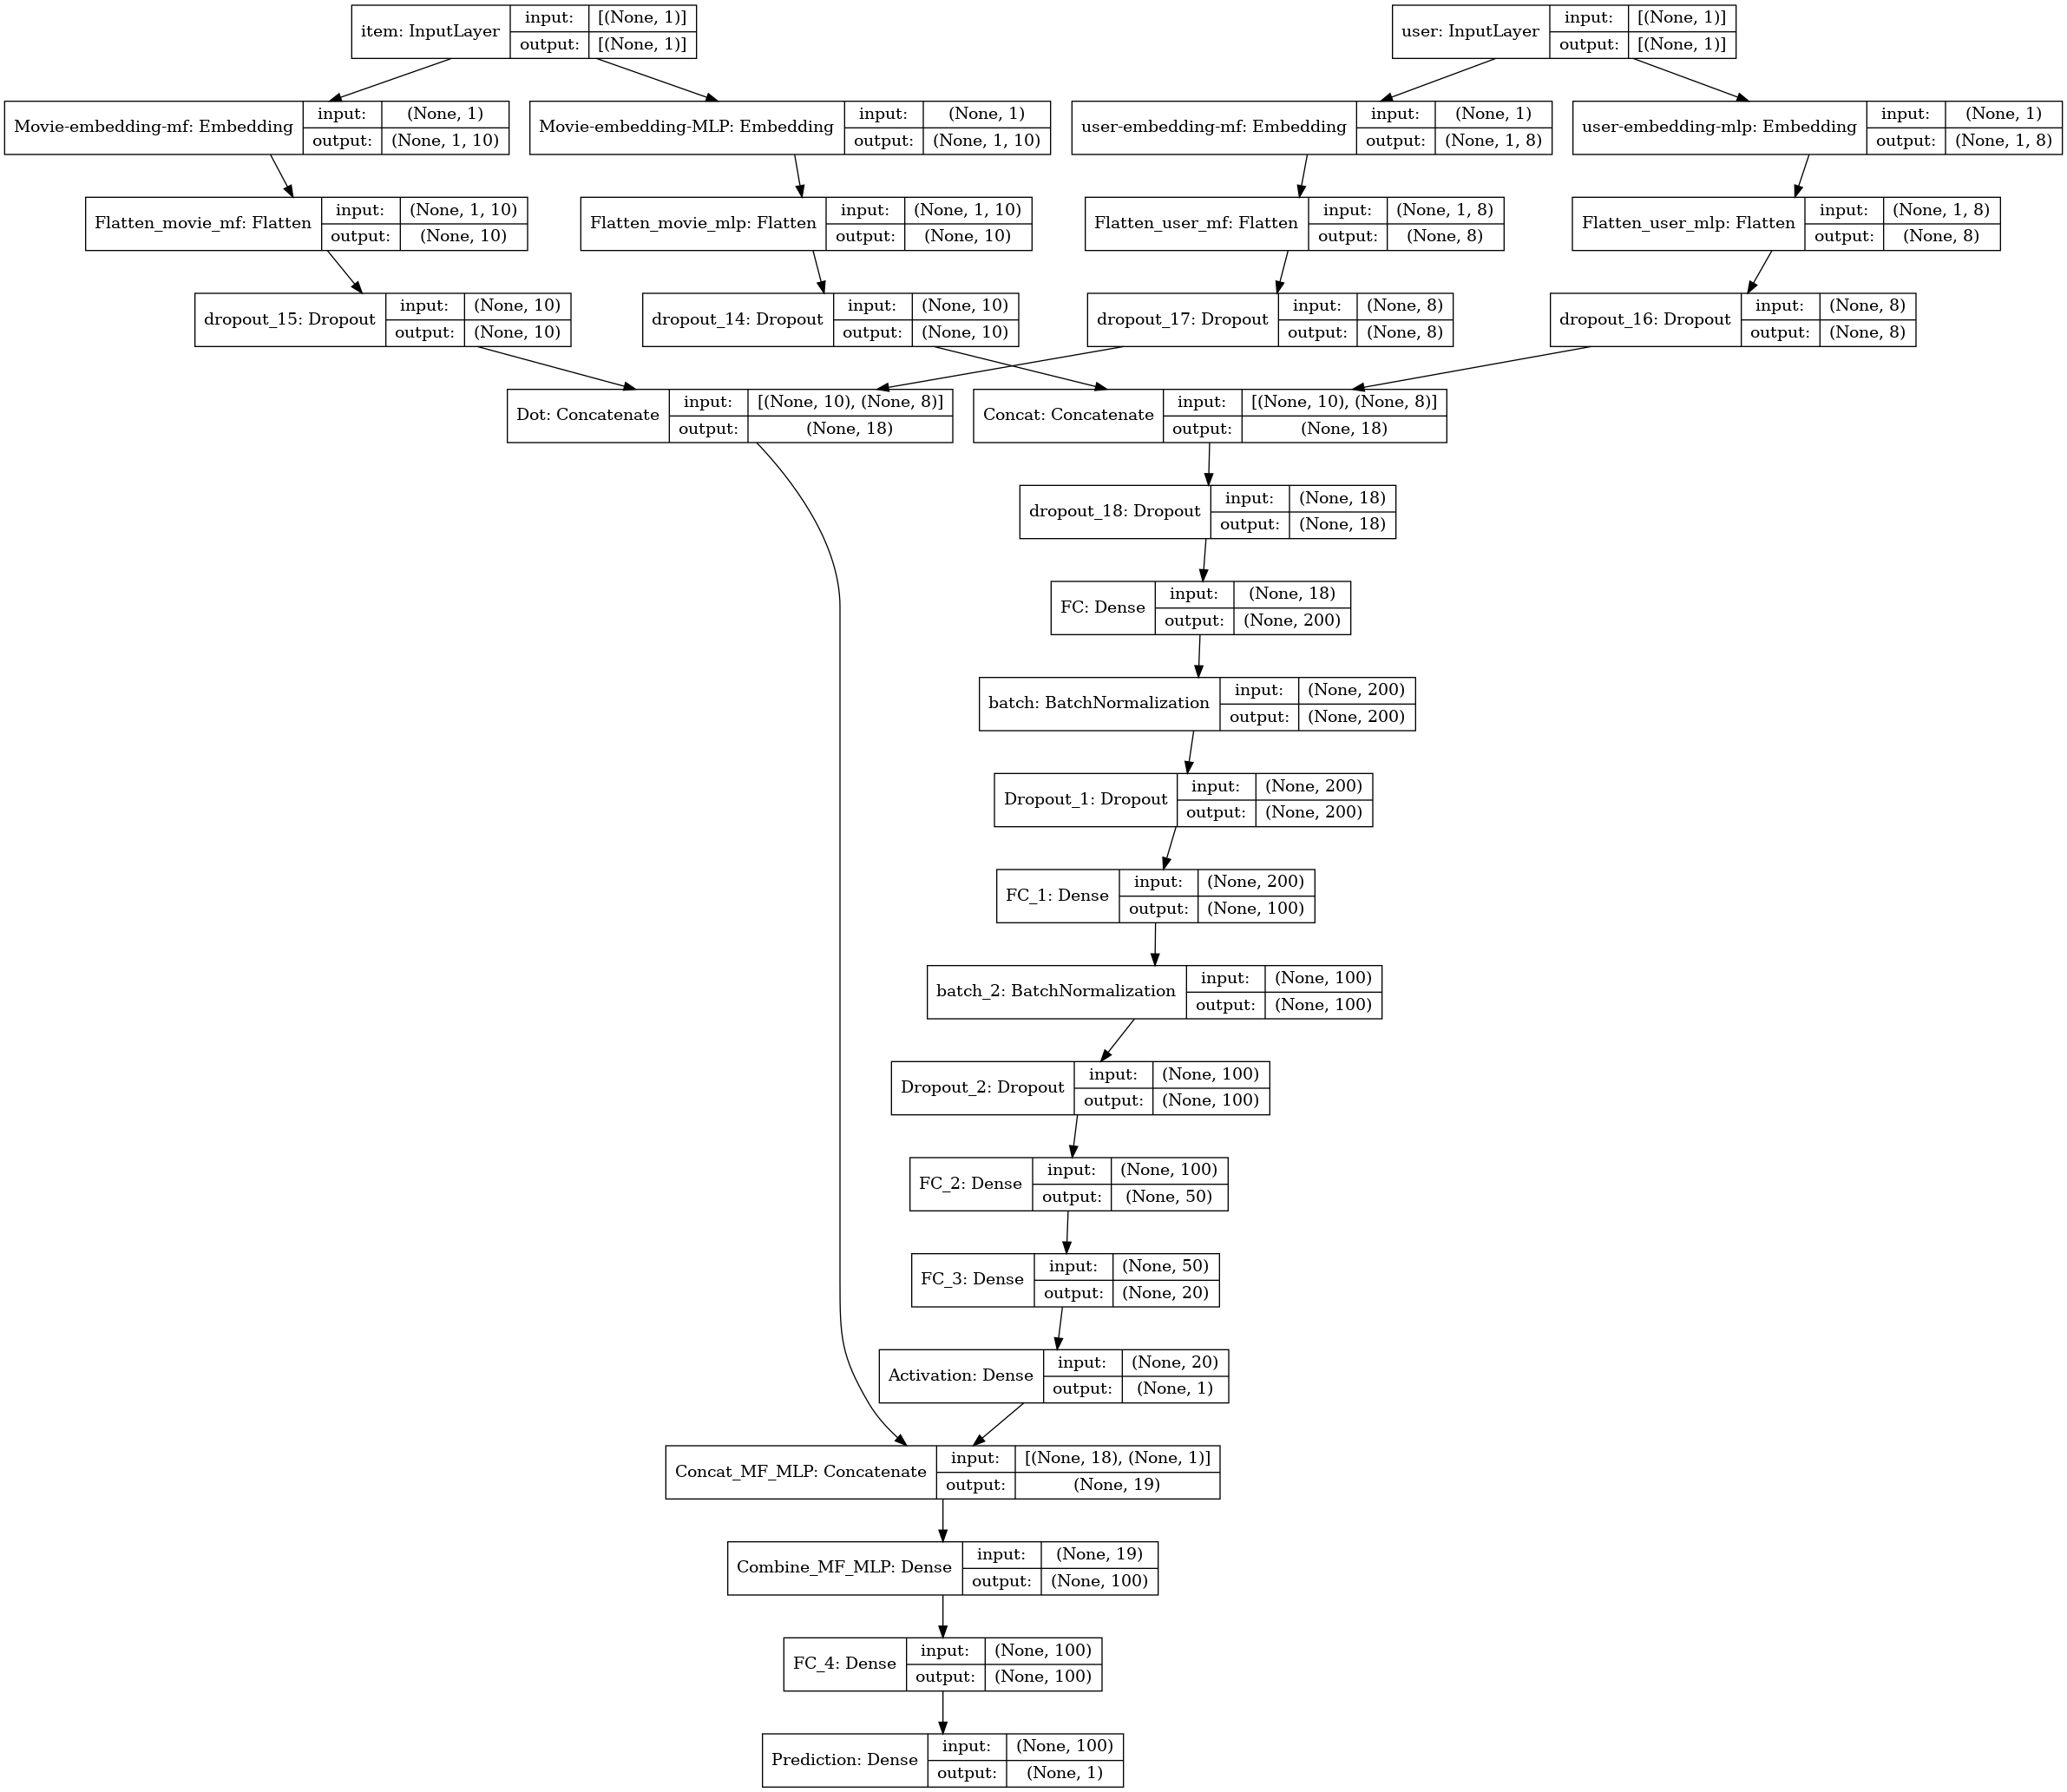

In [46]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [47]:
history = model.fit([train.userId, train.itemId], train.rating,batch_size = 256, epochs=25, verbose=1, validation_split=0.1)

Epoch 1/25
2814/2814 [==============================] - 8s 3ms/step - loss: -38.9772 - val_loss: -39.3131
Epoch 2/25
2814/2814 [==============================] - 8s 3ms/step - loss: -39.3724 - val_loss: -39.3131
Epoch 3/25
2814/2814 [==============================] - 8s 3ms/step - loss: -39.3724 - val_loss: -39.3131
Epoch 4/25
2814/2814 [==============================] - 8s 3ms/step - loss: -39.3724 - val_loss: -39.3131
Epoch 5/25
2814/2814 [==============================] - 8s 3ms/step - loss: -39.3724 - val_loss: -39.3131
Epoch 6/25
2814/2814 [==============================] - 8s 3ms/step - loss: -39.3724 - val_loss: -39.3131
Epoch 7/25
2814/2814 [==============================] - 8s 3ms/step - loss: -39.3724 - val_loss: -39.3131
Epoch 8/25
 731/2814 [======>.......................] - ETA: 5s - loss: -39.3868

KeyboardInterrupt: 

In [42]:
from sklearn.metrics import mean_absolute_error
y_hat_2 = np.round(model.predict([test.userId, test.itemId]),0)
print(mean_absolute_error(y_true, y_hat_2))

print(mean_absolute_error(y_true, model.predict([test.userId, test.itemId])))

0.6763279711260636
0.7144007101818736
